In [1]:
import numpy as np
from matplotlib import collections as mc

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

In [2]:
def load_data(fn):
    return np.load(fn)


data = load_data("field_data/0000.npy")

print(data.shape)

(4141, 2, 2)


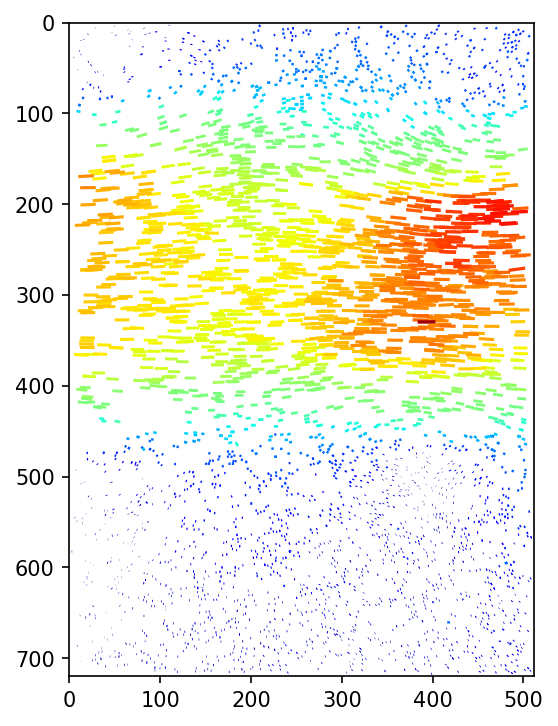

In [5]:
# def vis_data(data, data2=None):
def vis_data(*data, fn=None, save=False):
    
    def vis_lines_using_ax(lines, ax):
    
        ns = np.linalg.norm(lines[:,0] - lines[:,1], axis=1)

        lines = [[ (l[0][0], l[0][1]), (l[1][0], l[1][1]) ] for l in lines]

        c = np.sign(ns-10) * np.power(ns-10, 2.0) / 10 + 10
        linewidths = 1 + c / 30

        sorted_index = linewidths.argsort()
        
        lines = [lines[i] for i in sorted_index]
        linewidths = linewidths[sorted_index]
        c = c[sorted_index]
        
        lc = mc.LineCollection(lines, array=c, cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=20), linewidths=linewidths)

        ax.add_collection(lc)

        ax.set_xlim(0, 512)
        ax.set_ylim(0, 720)
        ax.set_aspect(1)

        ax.invert_yaxis()
    
    V_NUM = len(data)
    
    fig, axs = plt.subplots(1, V_NUM, figsize=(4*V_NUM,8), dpi=150)

    if V_NUM == 1:
        axs = [axs]

    for d,a in zip(data, axs):
        vis_lines_using_ax(d, a)
        
    if save:
        assert fn
        plt.savefig(fn, bbox_inches='tight')

    plt.show()
#     plt.cla()

vis_data(data)


In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def denoise(data):
    
    X = data[:, 0]
    Y = data[:, 1] - X
    
    y1 = Y[:, 0:1]
    y2 = Y[:, 1:2]
    
#     print("X.shape", X.shape)
#     print("y1.shape", y1.shape)
    
    kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + 4.0 * WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    gp1 = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(X, y1)
    gp2 = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(X, y2)
    
    y1_denoised = gp1.predict(X, return_cov=False)
#     print("y1_denoised.shape", y1_denoised.shape)
    y2_denoised = gp2.predict(X, return_cov=False)
    
    y_denoised = np.concatenate([y1_denoised, y2_denoised], axis=1)
    
    y_denoised += X
    
    data_denoised = np.concatenate([X[:,np.newaxis,:], y_denoised[:,np.newaxis,:]], axis=1)
    
    return data_denoised

data_denoised = denoise(data)

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from scipy.stats import kde

def vis_noise(error):
    
    print(error.shape)
    
    # the random data
#     x = np.random.randn(1000)
#     y = np.random.randn(1000)

    x = error[:,0,0]
    y = error[:,0,1]

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    axScatter.grid()
    # the scatter plot:
    axScatter.scatter(x, y, s=10, edgecolor='black', linewidth=0.3)
#     axScatter.hist2d(x, y, bins=100)

    axScatter.set_axisbelow(True)

    nbins = 30
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    # now determine nice limits by hand:
    binwidth = 0.08
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
#     lim = (int(xymax/binwidth) + 1) * binwidth
    lim = 3

    axScatter.set_xlim((-lim, lim))
    axScatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    print("bins", bins.shape)
    axHistx.hist(x, bins=bins,edgecolor='black', linewidth=0.5)
    axHisty.hist(y, bins=bins, orientation='horizontal', edgecolor='black', linewidth=0.5)

#     axHistx.set_xlim(axScatter.get_xlim())
#     axHisty.set_ylim(axScatter.get_ylim())

    axHistx.set_ylim((0, 750))
    axHisty.set_xlim((0, 750))
    
    axScatter.set_xlabel("$V_x$",fontsize=16)
    axScatter.set_ylabel("$V_y$",fontsize=16)
    
    plt.show()

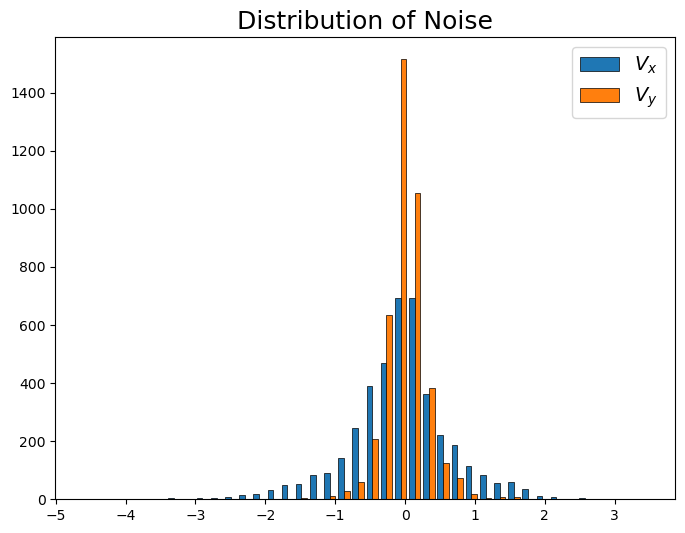

(4141, 1, 2)
bins (76,)


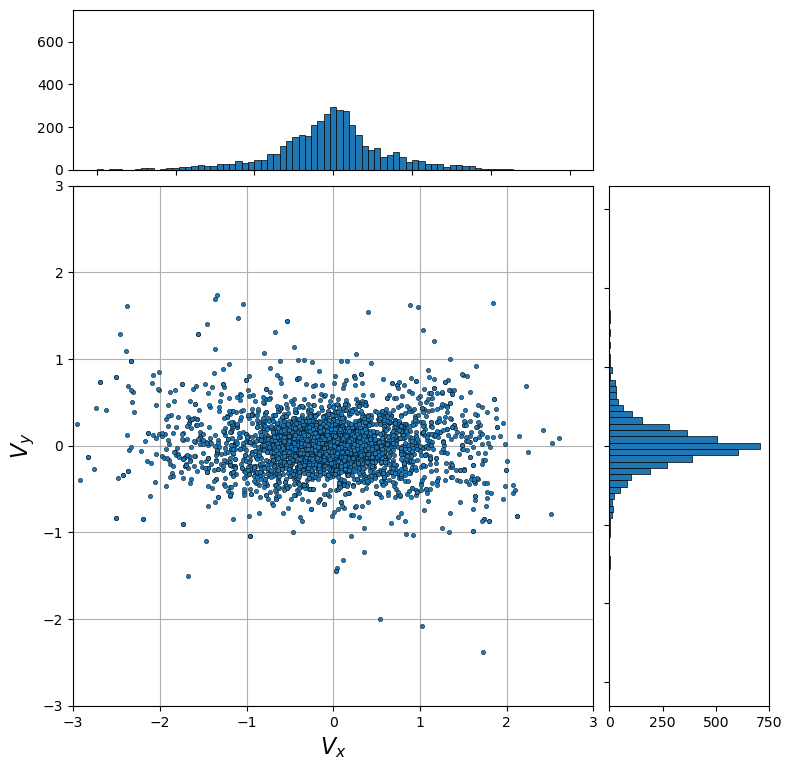

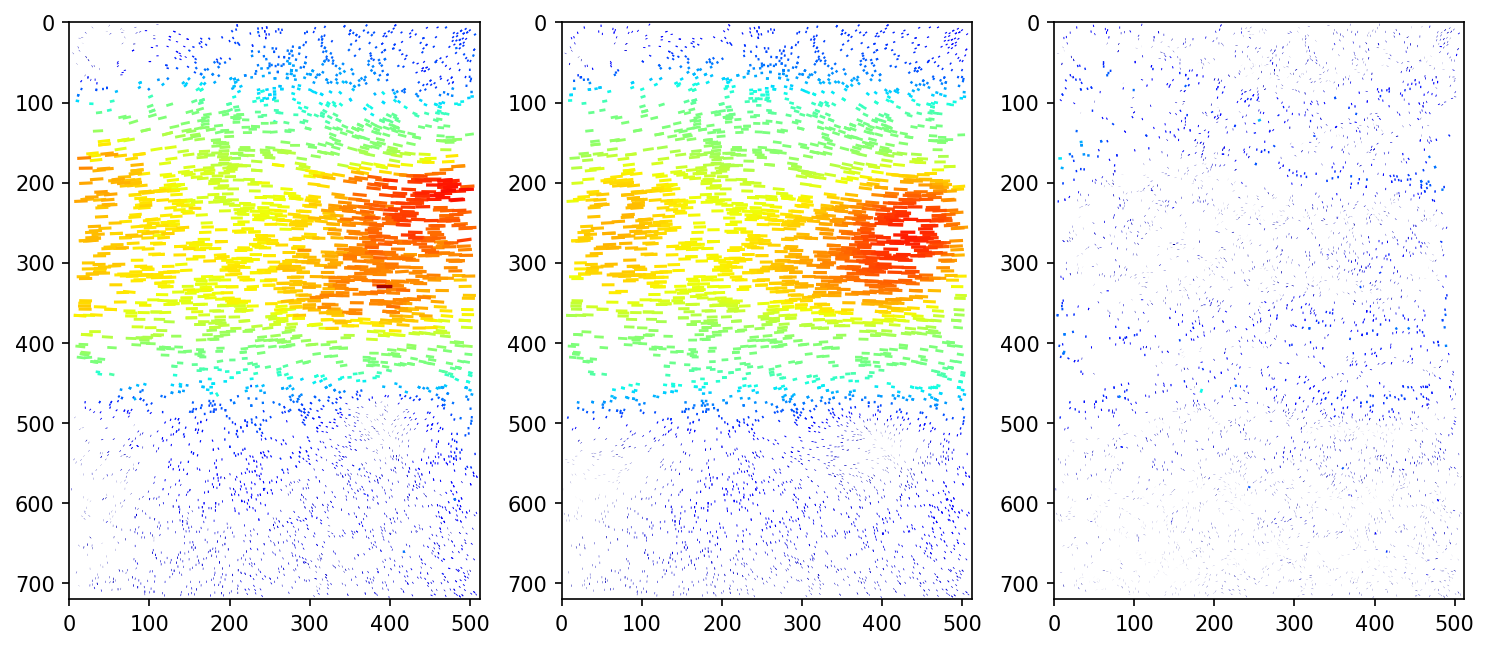

In [182]:
error = data_denoised[:, 1:2] - data[:, 1:2]

# data_1 = load_data("field_data/0001.npy")
# data_1_denoised = denoise(data_1)

import matplotlib.pyplot as plt

# print((error ** 2).sum(-1)[:,None,:].shape)
# print(error.shape)
plt.figure(1, figsize=(8, 6))
plt.hist(error[:,0], bins=40, edgecolor='black', linewidth=0.5)
plt.legend(["$V_x$", "$V_y$"], fontsize=14)
plt.title("Distribution of Noise", fontsize=18)
plt.show()
# print(error.max())
# print(error.min())
# print((error==0).sum())


vis_noise(error)


error = error[:,:,:2]
error = np.concatenate([data[:, 0:1], error+data[:, 0:1]], axis=1)
# vis_data(data, data_denoised)
vis_data(data, data_denoised, error)

In [ ]:
import os

data_files = sorted(os.listdir("field_data"))

def denoise_and_save(fn):
    print(fn)
    data = np.load("field_data/" + fn)
    data_denoised = denoise(data)
    np.save("field_data_denoised/" + fn, data_denoised)
    

# import multiprocessing

# def driver_func():
#     PROCESSES = 40
#     with multiprocessing.Pool(PROCESSES) as pool:
#         pool.map(denoise_and_save, data_files)

# driver_func()


for fn in data_files[200:400]:
    denoise_and_save(fn)


0200.npy
0201.npy
0202.npy
0203.npy
0204.npy
0205.npy
0206.npy
0207.npy
0208.npy
0209.npy
0210.npy
0211.npy
0212.npy
0213.npy
0214.npy
0215.npy
0216.npy
0217.npy
0218.npy
0219.npy
0220.npy
0221.npy
0222.npy
0223.npy
0224.npy


/home/dingshizhe/anaconda3/envs/wangzheng/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/dingshizhe/anaconda3/envs/wangzheng/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


0225.npy
0226.npy


In [ ]:
import os

data_files = sorted(os.listdir("field_data"))

# for fn in data_files[200:]:
for fn in data_files:
    print(fn)
    data = np.load("field_data/" + fn)
#     data_denoised = denoise(data)
    data_denoised = np.load("field_data_denoised/" + fn)
    error = data_denoised[:, 1:2] - data[:, 1:2]
    error = np.concatenate([data[:, 0:1], error+data[:, 0:1]], axis=1)

    vis_data(data, data_denoised, error, fn="vis_denoise_effect/"+fn.replace(".npy", ".jpg"), save=True)
    
#     break

0200.npy
0201.npy
0202.npy
0203.npy
0204.npy
0205.npy
0206.npy
0207.npy
0208.npy
0209.npy
0210.npy
0211.npy
0212.npy
0213.npy
0214.npy
0215.npy
0216.npy
0217.npy
0218.npy
0219.npy
0220.npy


/home/dingshizhe/anaconda3/envs/wangzheng/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0221.npy
0222.npy
0223.npy
0224.npy
0225.npy
0226.npy
0227.npy
0228.npy
0229.npy
0230.npy
0231.npy
0232.npy
0233.npy
0234.npy
0235.npy
0236.npy
0237.npy
0238.npy
0239.npy
0240.npy
0241.npy
0242.npy
0243.npy
0244.npy
0245.npy
0246.npy
0247.npy
0248.npy
0249.npy
0250.npy
0251.npy
0252.npy
0253.npy
0254.npy
0255.npy
0256.npy
0257.npy
0258.npy
0259.npy
0260.npy
0261.npy
0262.npy
0263.npy
0264.npy
0265.npy
0266.npy
0267.npy
0268.npy
0269.npy
0270.npy
0271.npy
0272.npy
0273.npy
0274.npy
0275.npy
0276.npy
0277.npy
0278.npy
0279.npy
0280.npy
0281.npy
0282.npy
0283.npy
0284.npy
0285.npy
0286.npy
0287.npy
0288.npy
0289.npy
0290.npy
0291.npy
0292.npy
